In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import time
import pickle
import seaborn as sns
import scipy.stats

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE =  10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [5]:
device   = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
classes  = {2:'GAL', 1:'QSO', 0:'STAR'}

In [7]:
plotpath = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

In [8]:
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [9]:
RUN             = '1'

seeds           = {'1':5123, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'


plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'


if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [10]:
decoded = {}
masked  = {}

In [11]:
os.path.join(root_decoded,'decoded_AE2_%s.npy'%(label_2))

'/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/decoded_AE2_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div.npy'

In [12]:
!ls -ltr '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/decoded_AE2_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div.npy'

ModuleCmd_Load.c(244):ERROR:105: Unable to locate a modulefile for 'git'
-rw-rw---- 1 vboehm vboehm 1396416634 Dec 21 11:43 /global/cscratch1/sd/vboehm/Datasets/decoded/sdss/decoded_AE2_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div.npy


In [13]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)
decoded['train'],decoded['valid'], decoded['test'], mean, std  = np.load(os.path.join(root_decoded,'decoded_AE2_%s.npy'%(label_2)), allow_pickle=True)

In [14]:
decoded_AE1_train,decoded_AE1_valid, decoded_AE1_test, mean_AE1, mean_AE1 = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)),allow_pickle=True)

In [15]:
print(len(decoded_AE1_test)),

69822


(None,)

In [16]:
encoded_test = np.vstack((encoded_test,encoded_valid))
decoded['test'] = np.vstack((decoded['test'],decoded['valid']))
decoded_AE1_test    = np.vstack((decoded_AE1_test,decoded_AE1_valid))

In [17]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new_relabeled.pkl'%label_),'rb'))

In [18]:
le

{6.0: 'GAL STARFORMING NOT BROADLINE',
 0.0: 'GAL NO SUBCLASS NOT BROADLINE',
 4.0: 'GAL STARBURST NOT BROADLINE',
 1.0: 'GAL NO SUBCLASS BROADLINE',
 13.0: 'QSO STARBURST BROADLINE',
 2.0: 'GAL AGN NOT BROADLINE',
 15.0: 'QSO STARFORMING BROADLINE',
 9.0: 'QSO NO SUBCLASS BROADLINE',
 7.0: 'GAL STARFORMING BROADLINE',
 8.0: 'QSO NO SUBCLASS NOT BROADLINE',
 11.0: 'QSO AGN BROADLINE',
 3.0: 'GAL AGN BROADLINE',
 10.0: 'QSO AGN NOT BROADLINE',
 5.0: 'GAL STARBURST BROADLINE',
 14.0: 'QSO STARFORMING NOT BROADLINE',
 12.0: 'QSO STARBURST NOT BROADLINE'}

In [19]:
res={}
for key in test.keys():
    if len(test[key].shape)>2:
        print(key)
        res[key] = np.vstack((test[key], valid[key]))
    else:
        try:
            res[key] = np.vstack((np.expand_dims(test[key],-1),np.expand_dims( valid[key],-1)))
            print(key)
        except:
            pass

spec
mask
noise
z
RA
DEC
class
subclass
SN
MJD
plate
fiber
mean
std
new_inf_labels
new_label
new_logp
old_logp


In [20]:
test = res

In [21]:
noise                = np.ma.array(np.squeeze(test['noise']),mask=~np.squeeze(test['mask'].astype('bool')))
masked_array         = np.ma.array((np.squeeze(test['spec'])-decoded_AE1_test)**2,mask=~np.squeeze(test['mask'].astype('bool')))
# get std for each spectrum

In [22]:
df_train = pd.read_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','training_set.csv'))
df_valid = pd.read_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','validation_set.csv'))
df_test  = pd.read_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','test_set.csv'))

In [23]:
df_test = pd.concat([df_test,df_valid]).reset_index()


In [24]:
df_test['recon_error_std_AE1'] = np.ma.std(masked_array*noise,axis=1)
clip=1
df_test['recon_error_AE1'] = np.ma.mean(np.ma.clip(masked_array*noise,a_min=np.zeros_like(df_test['recon_error_std_AE1'].to_numpy())[:,None],a_max=clip*df_test['recon_error_std_AE1'].to_numpy()[:,None]),axis=1)

In [25]:
np.unique(df_test.index,return_counts=True)

(array([     0,      1,      2, ..., 139639, 139640, 139641]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [26]:
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test']  = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))

In [27]:
masked['test'].shape

(139642, 1000)

In [28]:
def split_in_equal_bins(data, num_bins, sort_by, logp, num, ascending):
    ppb  = len(data)//num_bins
    data = data.sort_values(sort_by)
    bin_edges = [0]
    outliers  = []
    for ii in range(num_bins):
        dd = data.iloc[ii*ppb:(ii+1)*ppb]
        bin_edges.append(dd[sort_by].iloc[-1])
        dd = dd.sort_values(logp,ascending=ascending)
        dd['z-bin'] = np.ones(len(dd), dtype=int)*ii+1
        outliers.append(dd.iloc[0:num])
    return bin_edges, outliers

In [29]:
df_test.columns
df_test['DEC'] = test['DEC']

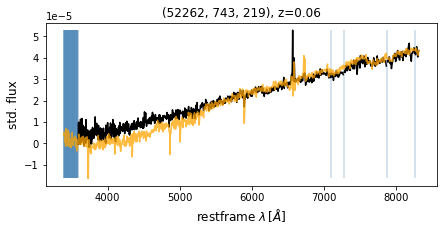

In [30]:
#reconstrucution plots for text
ind = df_test[(df_test[' mjd']==52262)&(df_test[' fiber']==561)&(df_test['plate']==743)].index[0]
data = test
outliers_decoded  = decoded['test'][ind]
outliers_input    = masked['test'][ind]
fi, ax = plt.subplots(1,1,figsize=(7,3))
for ii in range(1):
    ax.set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind],data['plate'][ind],data['fiber'][ii],data['z'][ind]))
    ax.plot(new_wl[1:],outliers_input/new_wl[1:], color='black', label='input', lw=1.5)
    ax.vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind].astype(bool))], ymin=min(min(outliers_decoded/new_wl[1:]),min(data['spec'][ind][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded/new_wl[1:]),max(data['spec'][ind][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)
    ax.plot(new_wl[1:],outliers_decoded/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
    ax.set_xlabel(r'restframe $\lambda \, [\AA]$')
    ax.set_ylabel(r'std. flux') 
plt.savefig(os.path.join(plotpath,'recon_52262_561_743.pdf'), bbox_inches='tight')

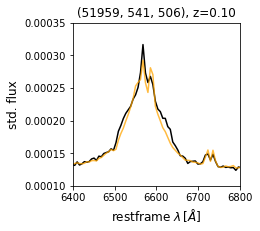

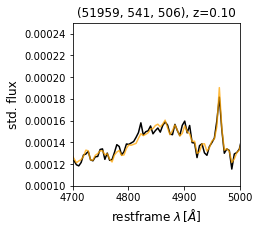

In [31]:
ind = df_train[(df_train[' mjd']==51959)&(df_train[' fiber']==519)&(df_train['plate']==541)].index[0]

data = train
outliers_decoded  = decoded_AE1_train[ind]#decoded['train'][ind]
outliers_input    = masked['train'][ind]
fi, ax = plt.subplots(1,1,figsize=(3,3))
for ii in range(1):
    ax.set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind],data['plate'][ind],data['fiber'][ii],data['z'][ind]))
    ax.plot(new_wl[1:],outliers_input/new_wl[1:], color='black', label='input', lw=1.5)
    ax.vlines(x=new_wl[1:][np.squeeze(~data['mask'][ind].astype(bool))], ymin=min(min(outliers_decoded/new_wl[1:]),min(data['spec'][ind][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded/new_wl[1:]),max(data['spec'][ind][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)
    ax.plot(new_wl[1:],outliers_decoded/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
    ax.set_xlabel(r'restframe $\lambda \, [\AA]$')
    ax.set_ylabel(r'std. flux') 
    ax.set_xlim(6400,6800)
    ax.set_ylim(1e-4,35e-5)
plt.savefig(os.path.join(plotpath,'recon_51959_519_541_H_alpha.pdf'), bbox_inches='tight')

fi, ax = plt.subplots(1,1,figsize=(3,3))
for ii in range(1):
    ax.set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind],data['plate'][ind],data['fiber'][ii],data['z'][ind]))
    ax.plot(new_wl[1:],outliers_input/new_wl[1:], color='black', label='input', lw=1.5)
    ax.vlines(x=new_wl[1:][np.squeeze(~data['mask'][ind].astype(bool))], ymin=min(min(outliers_decoded/new_wl[1:]),min(data['spec'][ind][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded/new_wl[1:]),max(data['spec'][ind][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)
    ax.plot(new_wl[1:],outliers_decoded/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
    ax.set_xlabel(r'restframe $\lambda \, [\AA]$')
    ax.set_ylabel(r'std. flux') 
    ax.set_xlim(4700,5000)
    ax.set_ylim(1e-4,25e-5)
plt.savefig(os.path.join(plotpath,'recon_51959_519_541_OIII.pdf'), bbox_inches='tight')

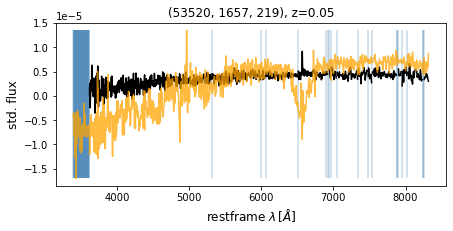

In [32]:
#reconstrucution plots for text
ind = df_test[(df_test[' mjd']==53520)&(df_test[' fiber']==126)&(df_test['plate']==1657)].index[0]
data = test
outliers_decoded  = decoded['test'][ind]
outliers_input    = masked['test'][ind]
fi, ax = plt.subplots(1,1,figsize=(7,3))
for ii in range(1):
    ax.set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind],data['plate'][ind],data['fiber'][ii],data['z'][ind]))
    ax.plot(new_wl[1:],outliers_input/new_wl[1:], color='black', label='input', lw=1.5)
    ax.vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind].astype(bool))], ymin=min(min(outliers_decoded/new_wl[1:]),min(data['spec'][ind][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded/new_wl[1:]),max(data['spec'][ind][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)
    ax.plot(new_wl[1:],outliers_decoded/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
    ax.set_xlabel(r'restframe $\lambda \, [\AA]$')
    ax.set_ylabel(r'std. flux') 
plt.savefig(os.path.join(plotpath,'recon_53520_126_1657.pdf'), bbox_inches='tight')

In [33]:
print(len(df_test), len(test['spec']),len(decoded['test']))

139642 139642 139642


In [34]:
res  = split_in_equal_bins(df_test[(df_test['new_label']==0)|(df_test['new_label']==1)],5, 'z','logp_marg',8, ascending=True)

In [35]:
resr = split_in_equal_bins(df_test[(df_test['new_label']==0)|(df_test['new_label']==1)],5, 'z','recon_error',8, ascending=False)

In [36]:
resrAE1 = split_in_equal_bins(df_test[(df_test['new_label']==0)|(df_test['new_label']==1)],5, 'z','recon_error_AE1',8, ascending=False)

In [37]:
bins=[0, 0.08315336, 0.111581735, 0.13774094, 0.17245772, 0.35116413]

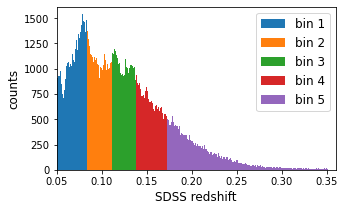

In [38]:
plt.figure(figsize=(5,3))
for ii in range(len(bins)-1):
    _=plt.hist(df_test['z'],bins=int(np.diff((bins[ii:ii+2]))*1000), range=bins[ii:ii+2],density=False,label='bin %d'%(ii+1))
plt.xlim(0.05,0.36)
plt.xlabel('SDSS redshift')
plt.ylabel('counts')
plt.legend()
#plt.savefig(os.path.join(plotpath,'redshift_bins.pdf'), bbox_inches='tight')
    #plt.vlines([min(df_test['z']), 0.08315336, 0.111581735, 0.13774094, 0.17245772, 0.35116413],ymin=0, ymax=1200,color='black')

In [39]:
df_extern                 = pd.read_csv('../external_data/Baronetal_weirdness.csv')

df_overlap_test           = df_extern.merge(df_test,how='inner',on=['plate',' mjd',' fiber']).set_index('index').reset_index()

reswl = split_in_equal_bins(df_overlap_test[(df_overlap_test['new_label']==0)|(df_overlap_test['new_label']==1)],1, 'z','logp_marg_corr',8, ascending=True)
resww = split_in_equal_bins(df_overlap_test[(df_overlap_test['new_label']==0)|(df_overlap_test['new_label']==1)],1, 'z',' weirdness',8, ascending=False)

In [40]:

fp = pd.concat(res[1])
fp = fp.round(decimals=2)
print(fp.columns)
for tag in ['Unnamed: 0', 'index', 'mask_fracs', 'recon_error_std','max_recon_error', 'supernova', 'logp','new_label']:
    try:
        fp.drop(columns=[tag], inplace=True)
    except:
        print(tag)
fp.rename(columns={' mjd':'MJD', ' fiber':'fiber', 'plate':'plate', 'logp_marg':'logp', 'logp_marg_corr':'logp_z_corrected'}, inplace=True)
print(fp)
fp.to_csv('top8_logp_results_by_z.csv')

fp = pd.concat(resr[1])
fp = fp.round(decimals=2)
print(fp.columns)
for tag in ['Unnamed: 0', 'index', 'mask_fracs', 'recon_error_std','max_recon_error', 'supernova', 'logp','new_label']:
    try:
        fp.drop(columns=[tag], inplace=True)
    except:
        print(tag)
fp.rename(columns={' mjd':'MJD', ' fiber':'fiber', 'plate':'plate', 'logp_marg':'logp', 'logp_marg_corr':'logp_z_corrected'}, inplace=True)

#fp.to_csv('top8_recon_results_by_z.csv')

fp = pd.concat(resrAE1[1])
fp = fp.round(decimals=2)
print(fp.columns)
for tag in ['Unnamed: 0', 'index', 'mask_fracs', 'recon_error_std','max_recon_error', 'supernova', 'logp','new_label']:
    try:
        fp.drop(columns=[tag], inplace=True)
    except:
        print(tag)
fp.rename(columns={' mjd':'MJD', ' fiber':'fiber', 'plate':'plate', 'logp_marg':'logp', 'logp_marg_corr':'logp_z_corrected'}, inplace=True)
#print(fp)
fp.to_csv('top8_recon_results_by_z_AE1.csv')

Index(['level_0', 'Unnamed: 0', 'index', ' mjd', ' fiber', 'plate',
       'new_label', 'RA', 'logp_marg', 'mask_fracs', 'z', 'recon_error_std',
       'recon_error', 'max_recon_error', 'supernova', 'logp', 'logp_marg_corr',
       'recon_error_std_AE1', 'recon_error_AE1', 'DEC', 'z-bin'],
      dtype='object')
        level_0    MJD  fiber  plate      RA   logp     z  recon_error  \
135114    65292  52405    429    954  180.76 -32.11  0.07         1.17   
120080    50258  51691    640    350  261.13 -26.84  0.08         5.66   
41266     41266  51820     45    429   27.30 -23.78  0.07         3.02   
23135     23135  51955    247    472  137.91 -22.17  0.07         9.93   
61461     61461  52258    399    412   47.03 -20.49  0.07         1.38   
1541       1541  53520    126   1657  244.10 -19.38  0.05        25.57   
32939     32939  53149    192   1649  228.34 -19.16  0.07         3.69   
670         670  53084    388   1440  168.91 -19.14  0.05        14.39   
64916     64916  5223

In [41]:
test['MJD'][res[1][0].index]

array([[52405],
       [51691],
       [51820],
       [51955],
       [52258],
       [53520],
       [53149],
       [53084]])

In [42]:
df_test[' mjd'][res[1][0].index]

135114    52405
120080    51691
41266     51820
23135     51955
61461     52258
1541      53520
32939     53149
670       53084
Name:  mjd, dtype: int64

/global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_0.pdf


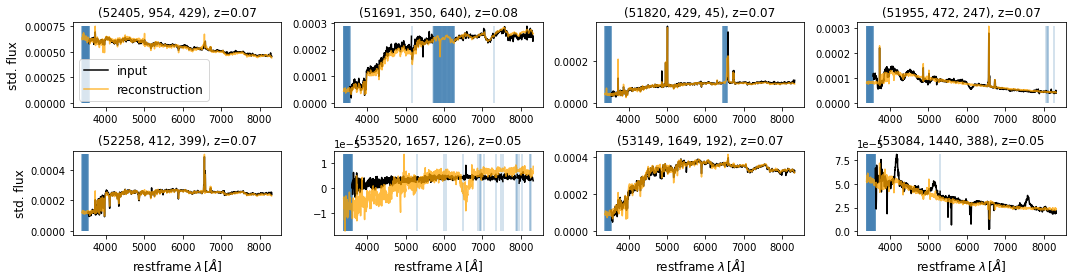

/global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_1.pdf


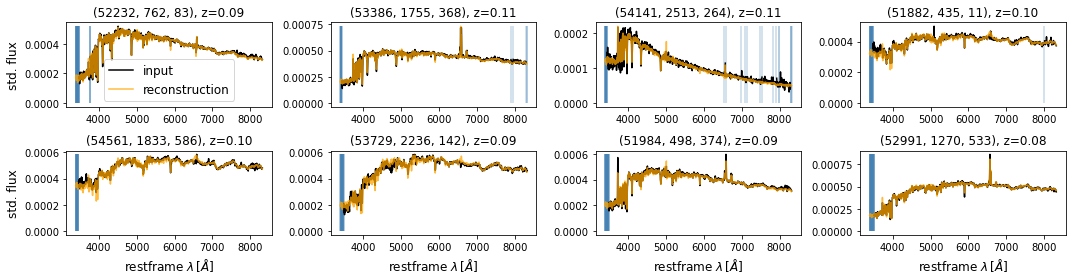

/global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_2.pdf


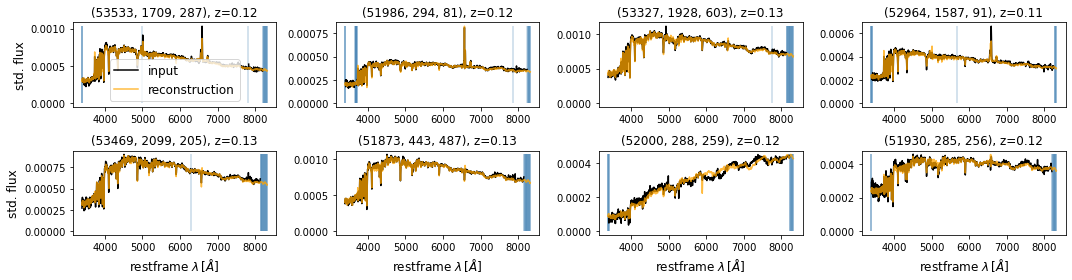

/global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_3.pdf


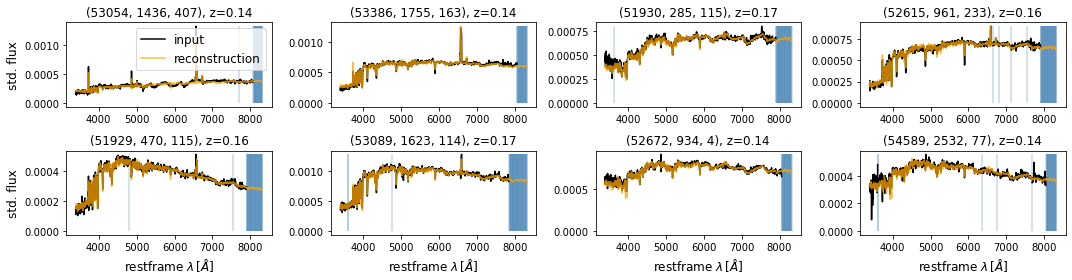

/global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_4.pdf


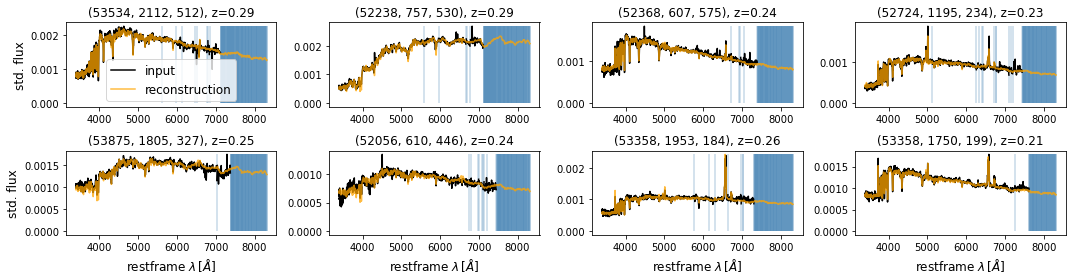

In [89]:
data = test
for mm in np.arange(5):
    ind_ood           = res[1][mm].index.to_numpy()
    outliers_decoded  = decoded['test'][ind_ood]
    outliers_input    = masked['test'][ind_ood]
    fi, ax = plt.subplots(2,4,figsize=(15,4))
    ax = ax.flatten()
    for ii in range(8):
        ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
        ax[ii].plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]/new_wl[1:]),min(data['spec'][ind_ood][ii][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded[ii]/new_wl[1:]),max(data['spec'][ind_ood][ii][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)
        ax[ii].plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
        if ii ==0:
            ax[ii].legend()
        if ii in [4,5,6,7]:
            ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
        if ii%4==0:
            ax[ii].set_ylabel(r'std. flux')        
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.17, hspace=0.4)
    plt.savefig(os.path.join(plotpath,'Figure8_%d.pdf'%mm), bbox_inches='tight')
    print(os.path.join(plotpath,'Figure8_%d.pdf'%mm))
    plt.show()
    plt.close()

In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

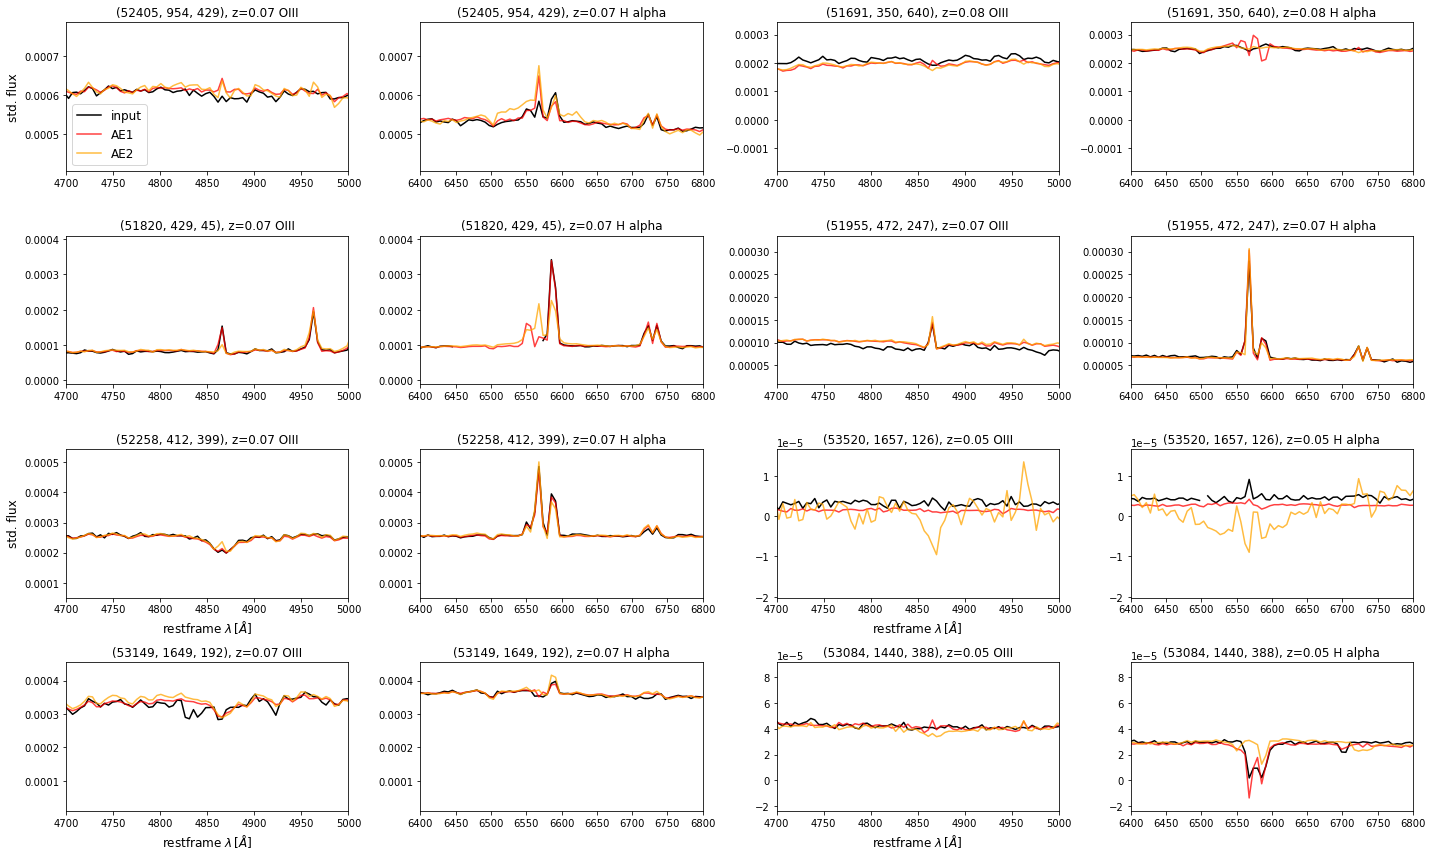

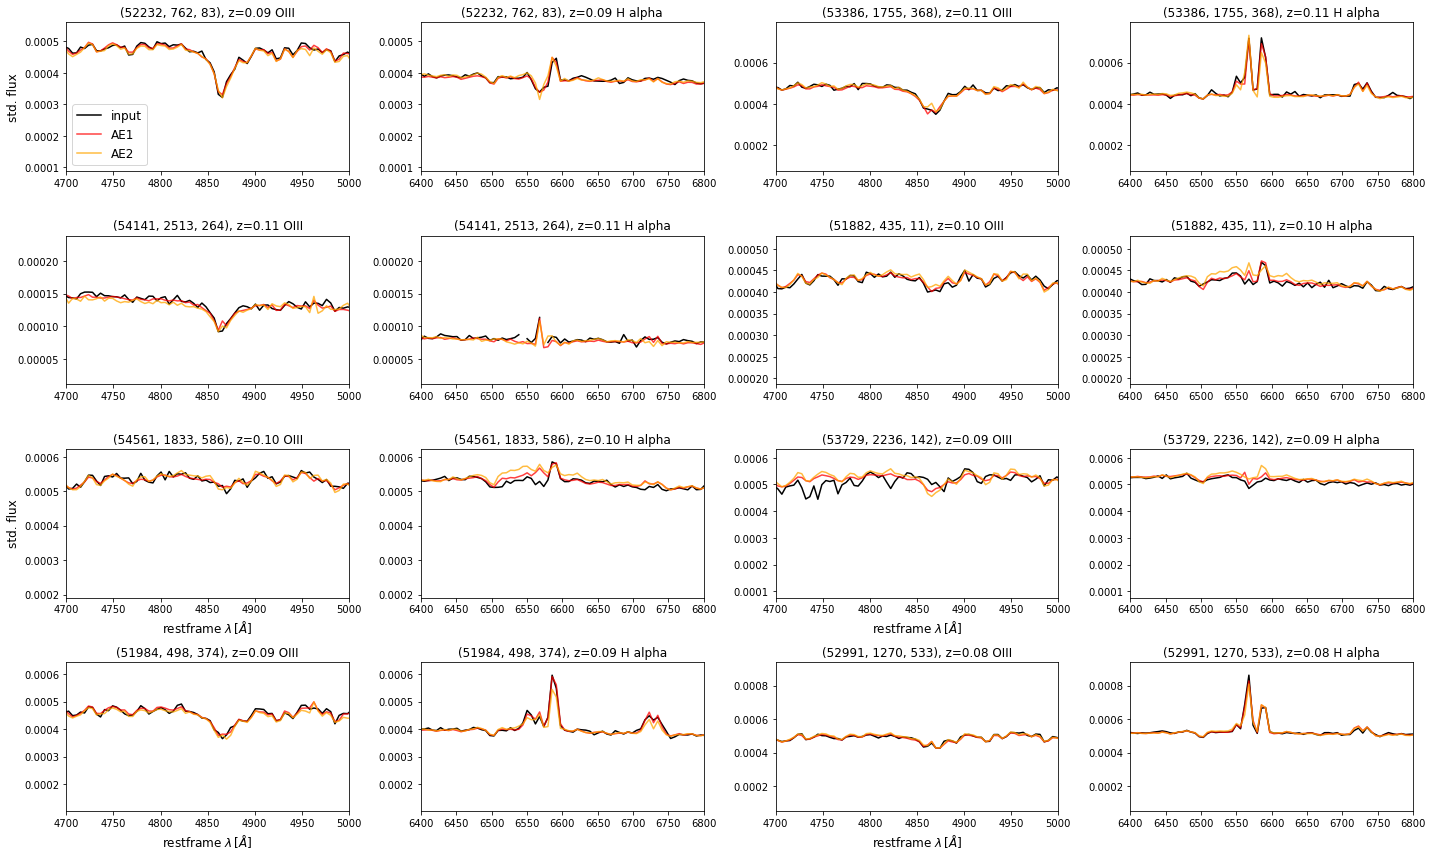

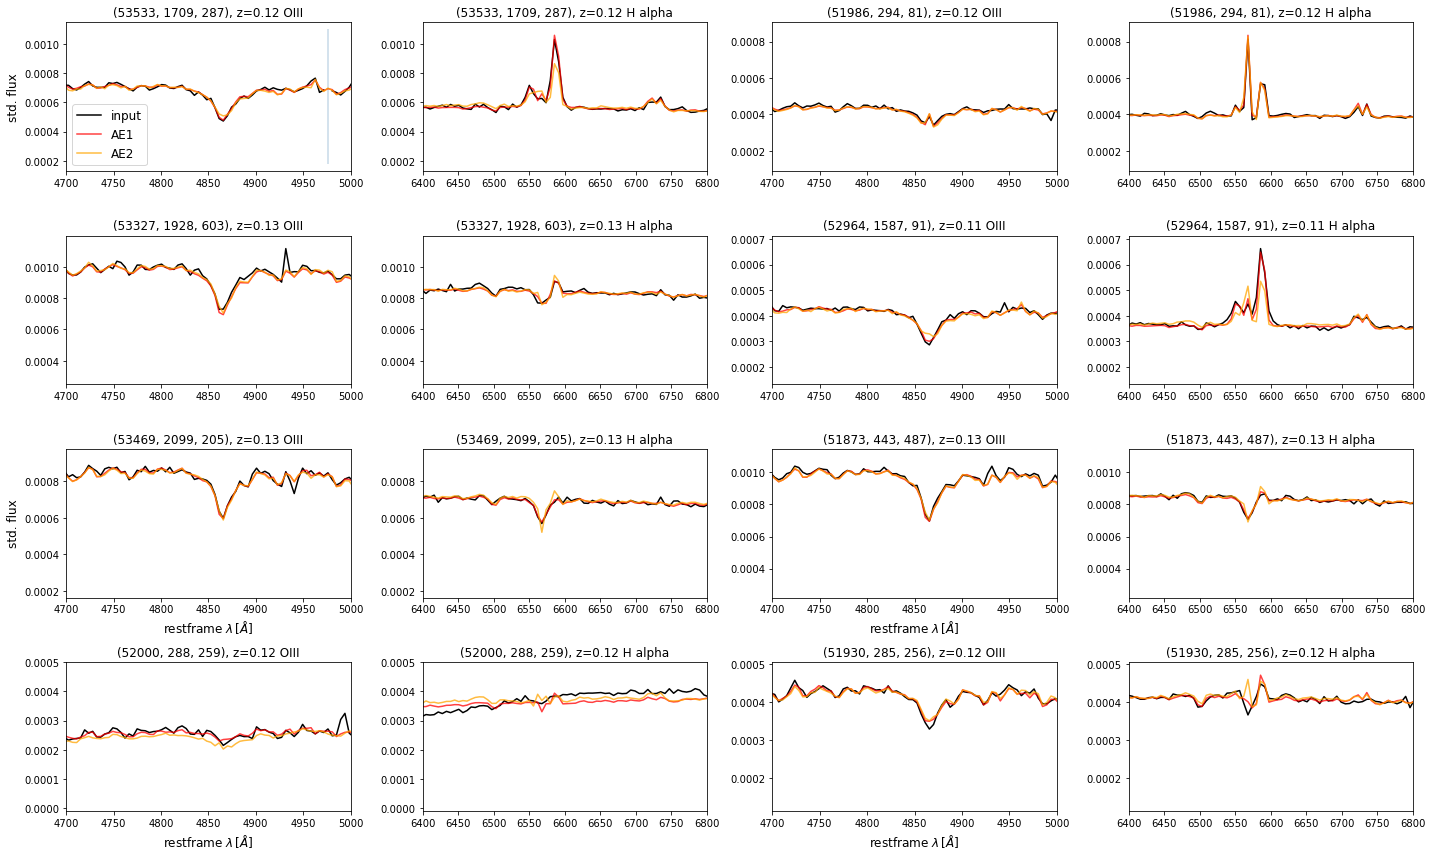

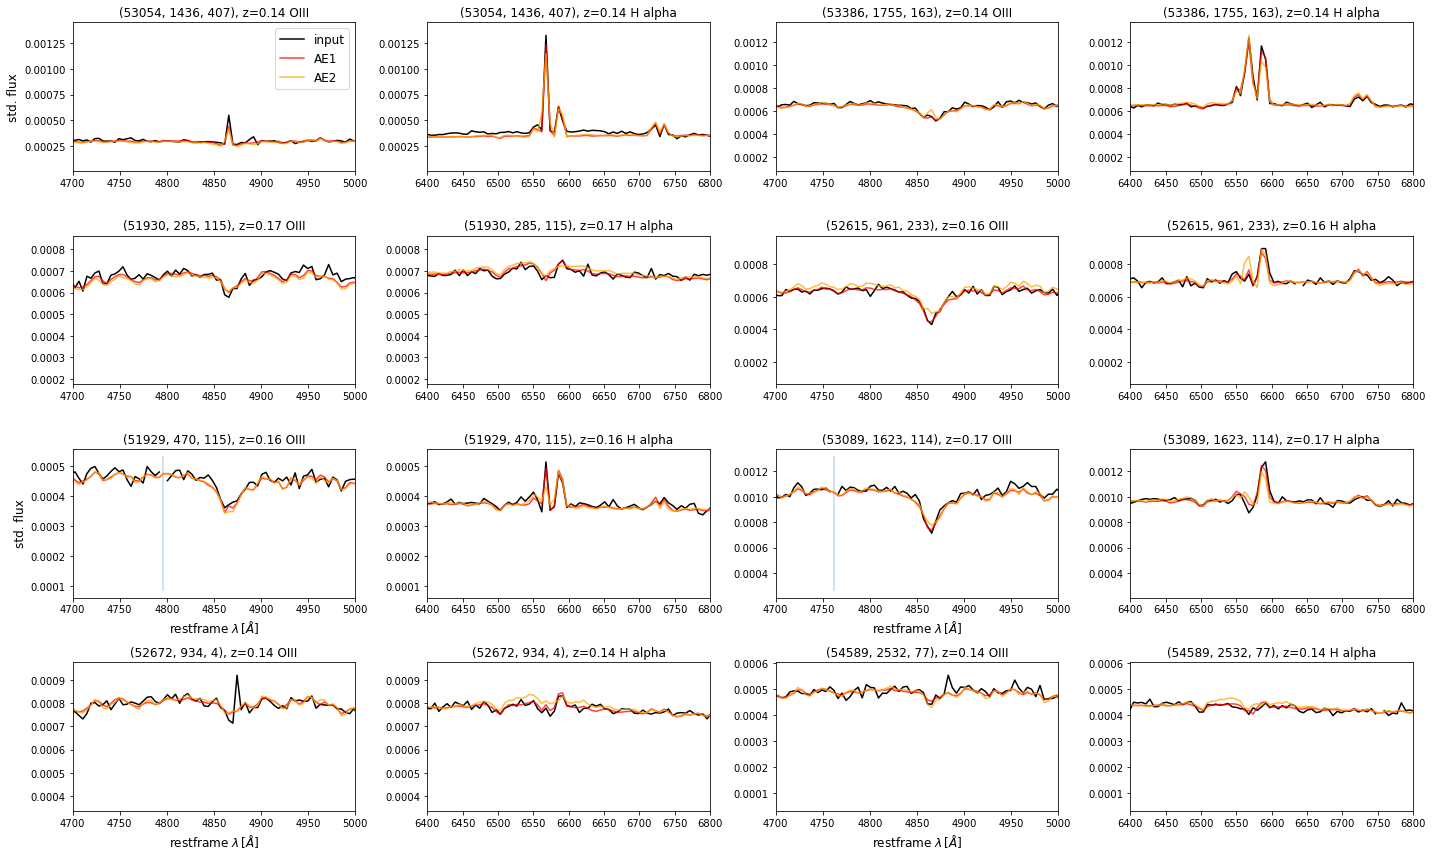

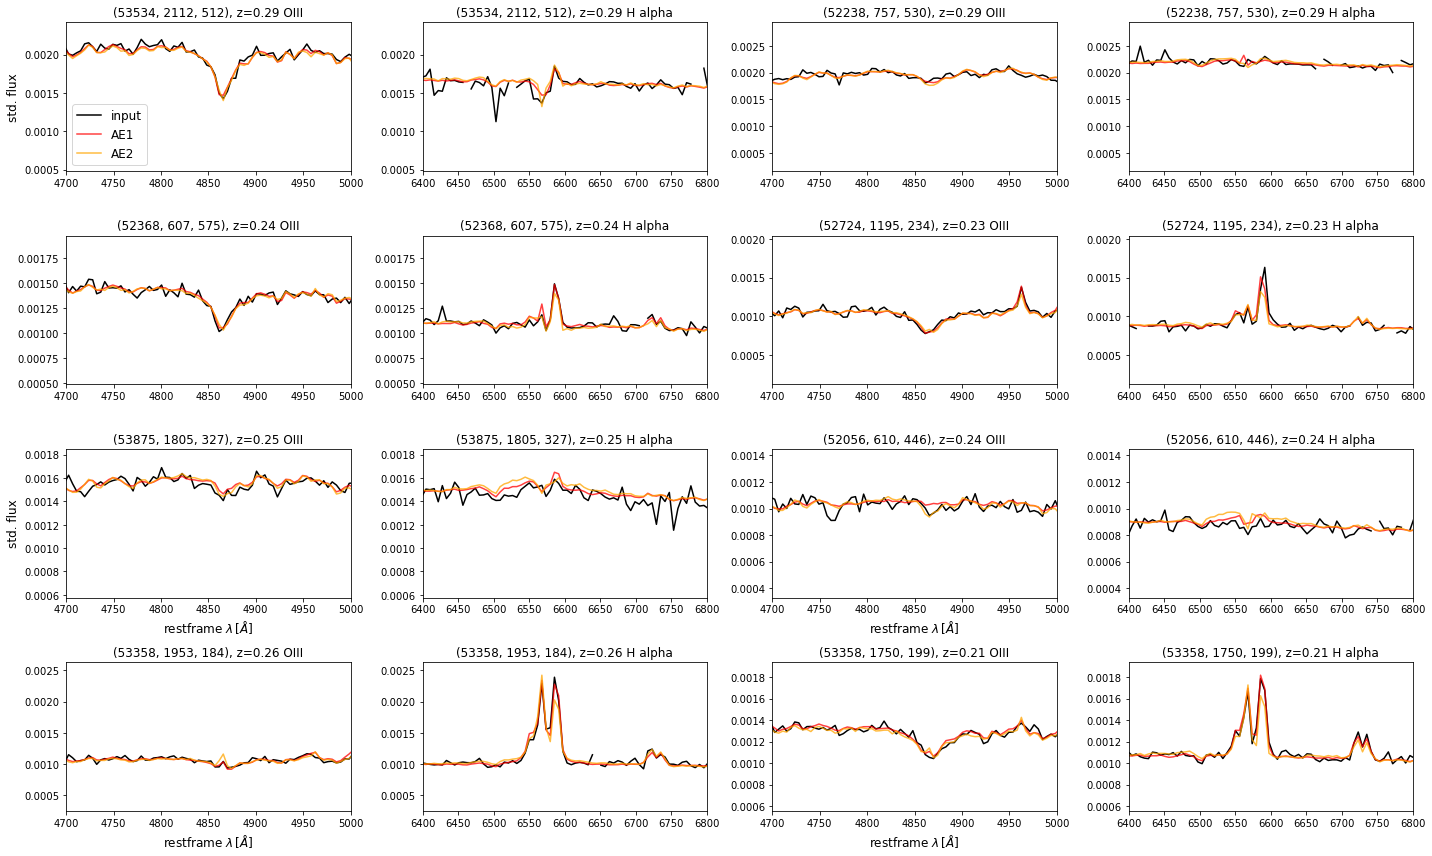

In [63]:
data = test
for mm in np.arange(5):
    ind_ood           = res[1][mm].index.to_numpy()
    outliers_decoded  = decoded['test'][ind_ood]
    outliers_decoded2 = decoded_AE1_test[ind_ood]

    outliers_input    = masked['test'][ind_ood]
    fi, ax = plt.subplots(4,2,figsize=(20,12))
    ax = ax.flatten()
    for ii in range(8):
        divider = make_axes_locatable(ax[ii])
        axs = divider.append_axes("right", size="100%", pad=1, sharey=ax[ii])
        ax[ii].set_title('(%d, %d, %d), z=%.2f OIII'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
        ax[ii].plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        ax[ii].plot(new_wl[1:],outliers_decoded2[ii]/new_wl[1:], label='AE1',ls='-', color='red', lw=1.5, alpha=0.75)
        ax[ii].plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='AE2',ls='-', color='orange', lw=1.5, alpha=0.75)
        axs.set_title('(%d, %d, %d), z=%.2f H alpha'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))

        axs.plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        axs.plot(new_wl[1:],outliers_decoded2[ii]/new_wl[1:], label='AE1',ls='-', color='red', lw=1.5, alpha=0.75)
        axs.plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='AE2',ls='-', color='orange', lw=1.5, alpha=0.75)
        if ii ==0:
            ax[ii].legend()
        if ii in [4,5,6,7]:
            ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
        if ii%4==0:
            ax[ii].set_ylabel(r'std. flux')
        ax[ii].set_xlim(4700,5000)
        axs.set_xlim(6400,6800)
        #ax[ii].relim()
# update ax.viewLim using the new dataLim
        ax[ii].autoscale_view()
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymax=ax[ii].get_ylim()[1],ymin=ax[ii].get_ylim()[0], color='steelblue',alpha=0.3)
        #ax[ii].set_ylim(1e-4,35e-5)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.17, hspace=0.4)
    plt.savefig(os.path.join(plotpath,'Figure8_%d_lines.pdf'%mm), bbox_inches='tight')
    plt.show()
    plt.close()

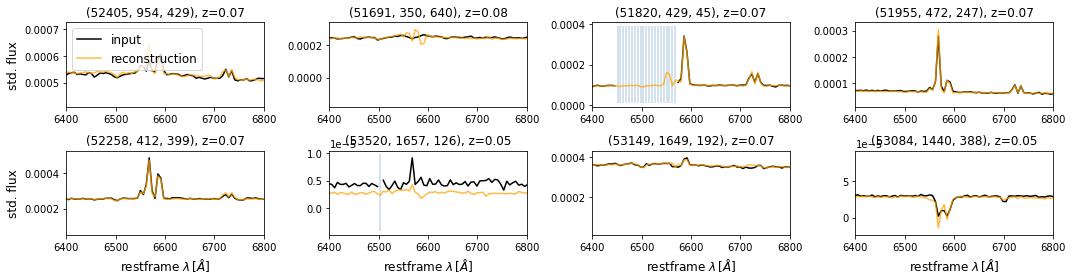

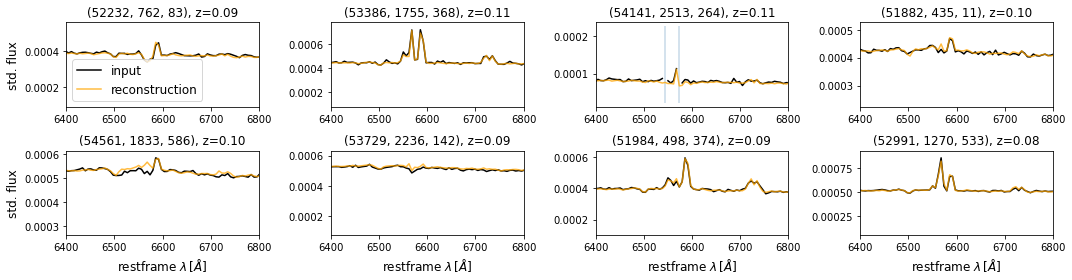

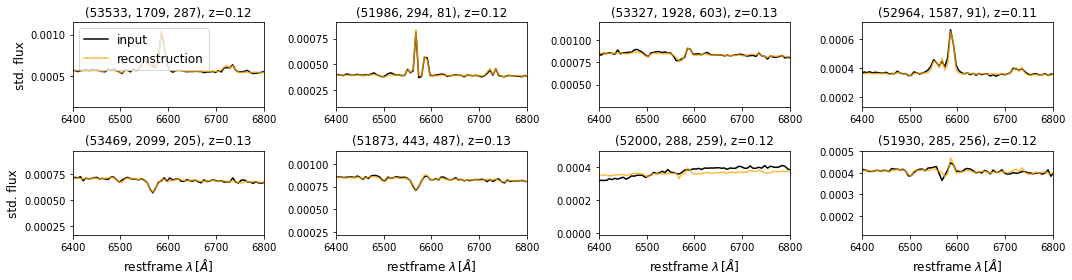

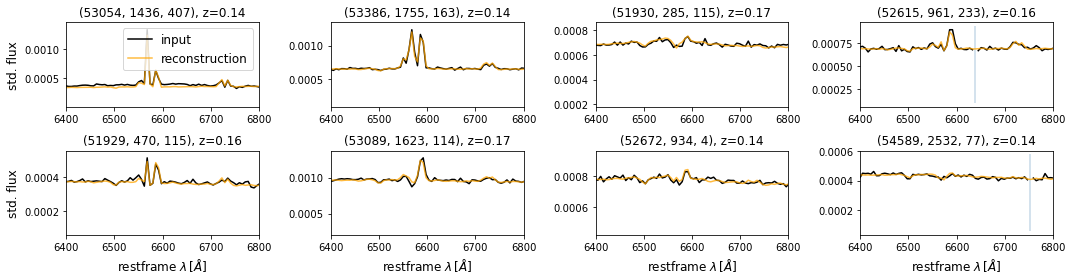

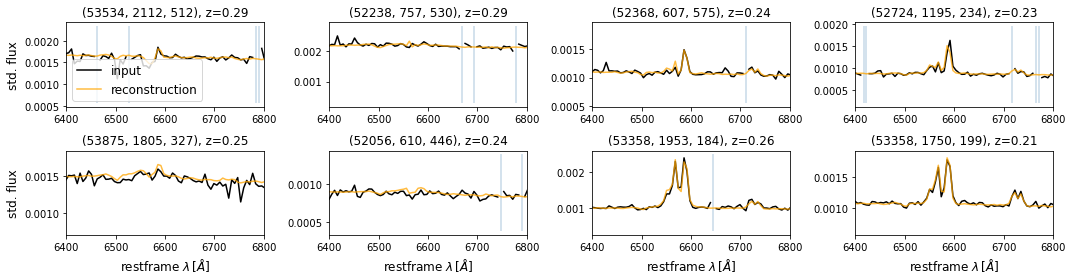

In [104]:
data = test
for mm in np.arange(5):
    ind_ood           = res[1][mm].index.to_numpy()
    outliers_decoded  = decoded_AE1_test[ind_ood]
    outliers_input    = masked['test'][ind_ood]
    fi, ax = plt.subplots(2,4,figsize=(15,4))
    ax = ax.flatten()
    for ii in range(8):
        ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
        ax[ii].plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        ax[ii].plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
        if ii ==0:
            ax[ii].legend()
        if ii in [4,5,6,7]:
            ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
        if ii%4==0:
            ax[ii].set_ylabel(r'std. flux')
        ax[ii].set_xlim(6400,6800)
        #ax[ii].relim()
# update ax.viewLim using the new dataLim
        ax[ii].autoscale_view()
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymax=ax[ii].get_ylim()[1],ymin=ax[ii].get_ylim()[0], color='steelblue',alpha=0.3)

        #ax[ii].set_ylim(1e-4,35e-5)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.17, hspace=0.4)
    plt.savefig(os.path.join(plotpath,'Figure8_%d_first_AE_Halpha.pdf'%mm), bbox_inches='tight')
    plt.show()
    plt.close()

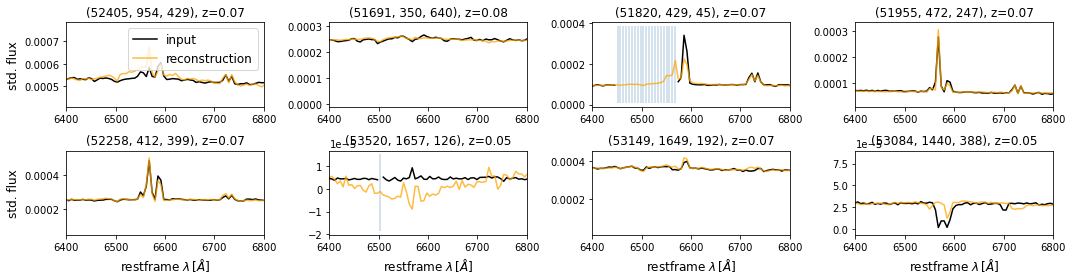

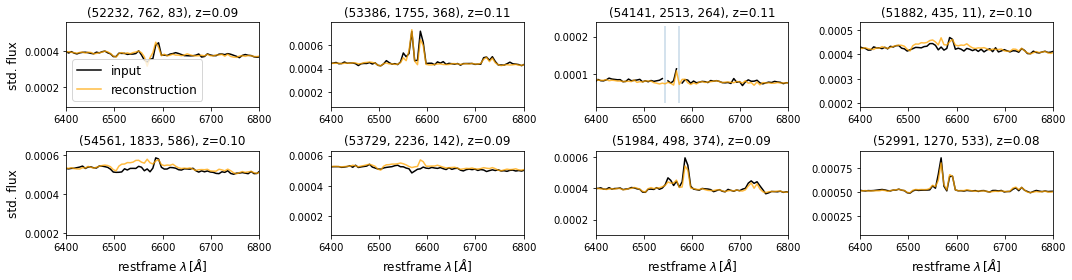

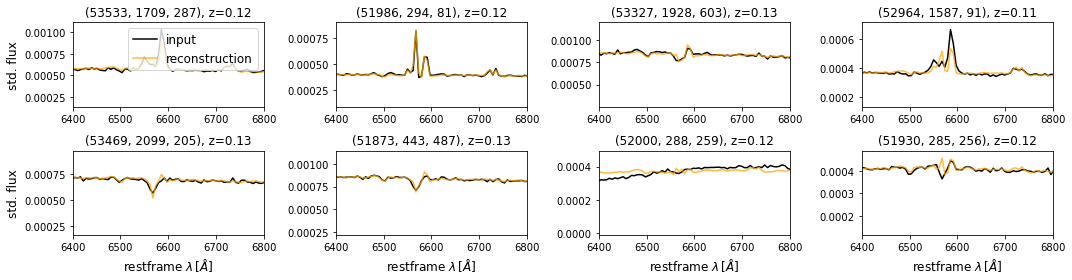

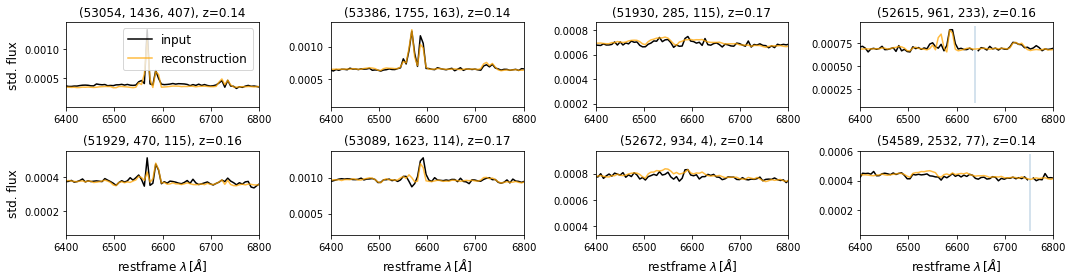

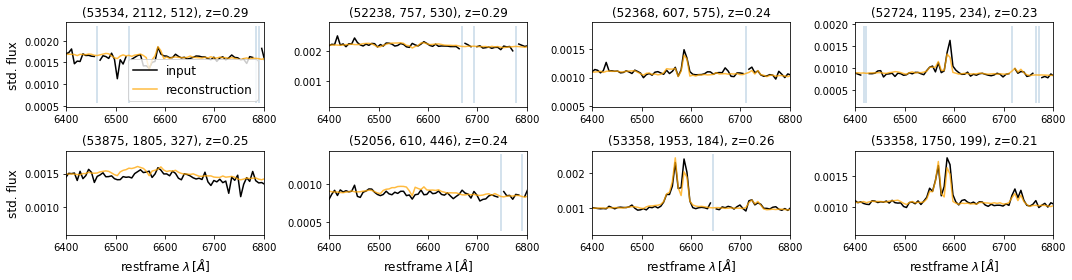

In [101]:
data = test
for mm in np.arange(5):
    ind_ood           = res[1][mm].index.to_numpy()
    outliers_decoded  = decoded['test'][ind_ood]
    outliers_input    = masked['test'][ind_ood]
    fi, ax = plt.subplots(2,4,figsize=(15,4))
    ax = ax.flatten()
    for ii in range(8):
        ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
        ax[ii].plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        ax[ii].plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
        if ii ==0:
            ax[ii].legend()
        if ii in [4,5,6,7]:
            ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
        if ii%4==0:
            ax[ii].set_ylabel(r'std. flux')
        ax[ii].set_xlim(6400,6800)
        #ax[ii].relim()
# update ax.viewLim using the new dataLim
        ax[ii].autoscale_view()
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymax=ax[ii].get_ylim()[1],ymin=ax[ii].get_ylim()[0], color='steelblue',alpha=0.3)

        #ax[ii].set_ylim(1e-4,35e-5)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.17, hspace=0.4)
    plt.savefig(os.path.join(plotpath,'Figure8_%d_Halpha.pdf'%mm), bbox_inches='tight')
    plt.show()
    plt.close()

In [90]:
!ls -ltr /global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_0.pdf

ModuleCmd_Load.c(244):ERROR:105: Unable to locate a modulefile for 'git'
-rw-rw---- 1 vboehm vboehm 139273 Jun 16 11:15 /global/homes/v/vboehm/codes/SDSS_PAE/figures/Figure8_0.pdf


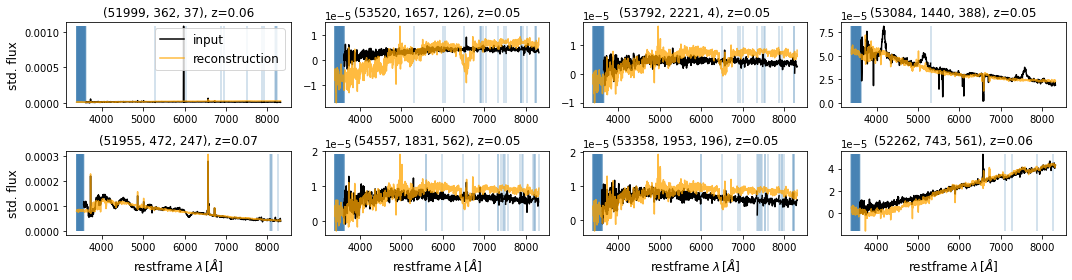

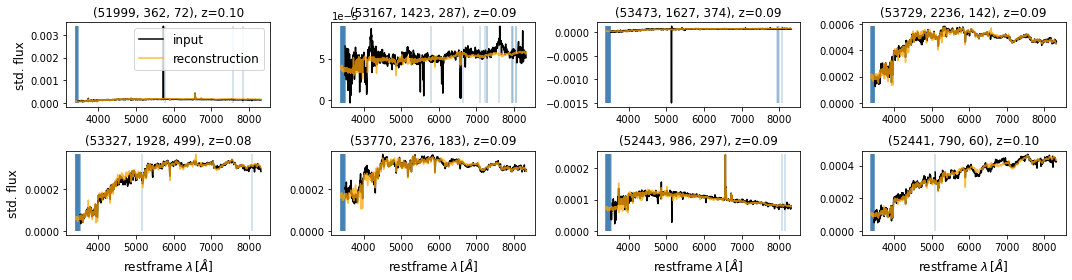

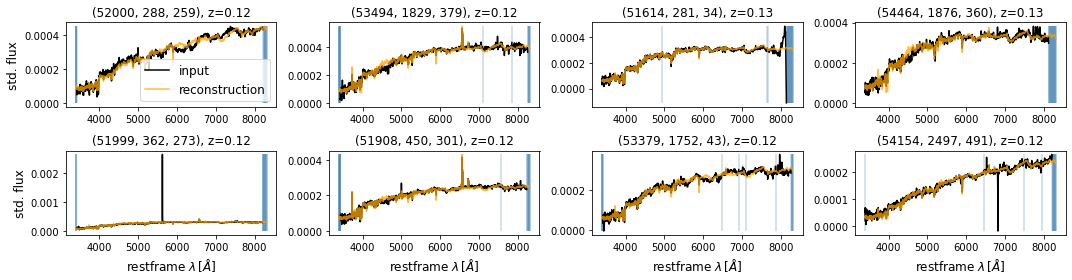

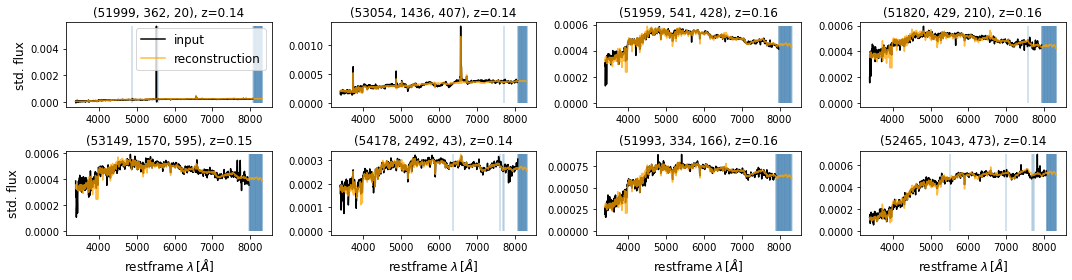

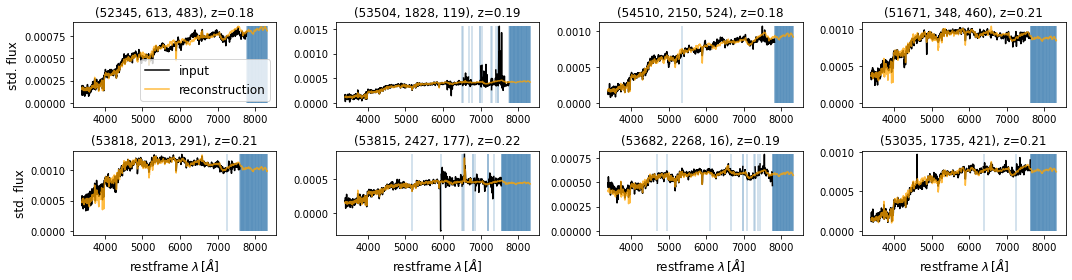

In [45]:
data = test
for mm in np.arange(5):
    ind_ood           = resr[1][mm].index.to_numpy()
    outliers_decoded  = decoded['test'][ind_ood]
    outliers_input    = masked['test'][ind_ood]

    fi, ax = plt.subplots(2,4,figsize=(15,4))
    ax = ax.flatten()
    for ii in range(0,8):
        ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
        ax[ii].plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        #ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]),min(data['spec'][ind_ood][ii])),ymax=max(max(outliers_decoded[ii]),max(data['spec'][ind_ood][ii])), color='steelblue',alpha=0.3)
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]/new_wl[1:]),min(data['spec'][ind_ood][ii][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded[ii]/new_wl[1:]),max(data['spec'][ind_ood][ii][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)

        ax[ii].plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
        if ii ==0:
            ax[ii].legend()
        if ii in [4,5,6,7]:
            ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
        if ii%4==0:
            ax[ii].set_ylabel(r'std. flux')        
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.17, hspace=0.4)
    plt.savefig(os.path.join(plotpath,'Figure9_%d.pdf'%mm), bbox_inches='tight')
    plt.show()
    plt.close()

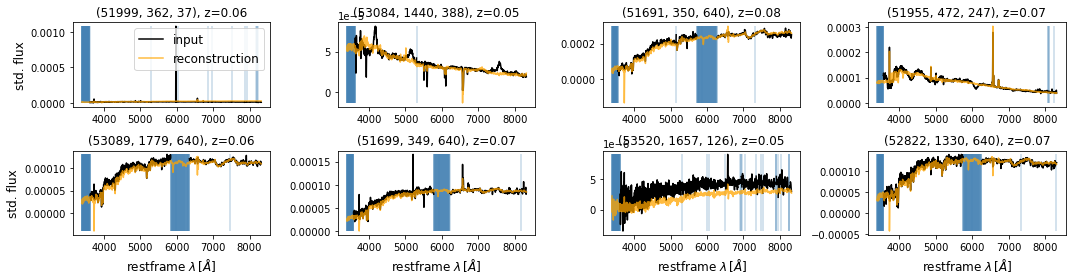

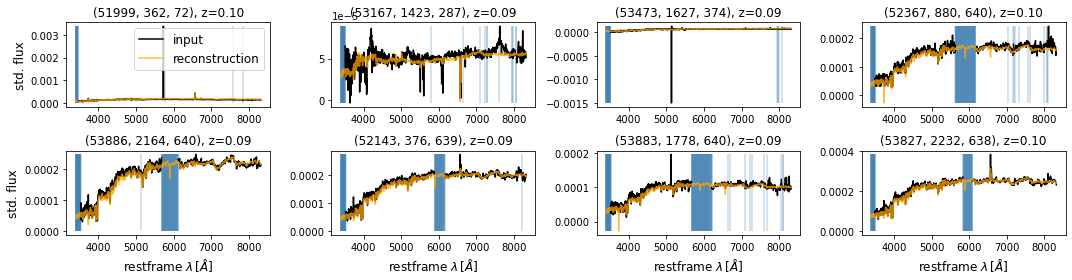

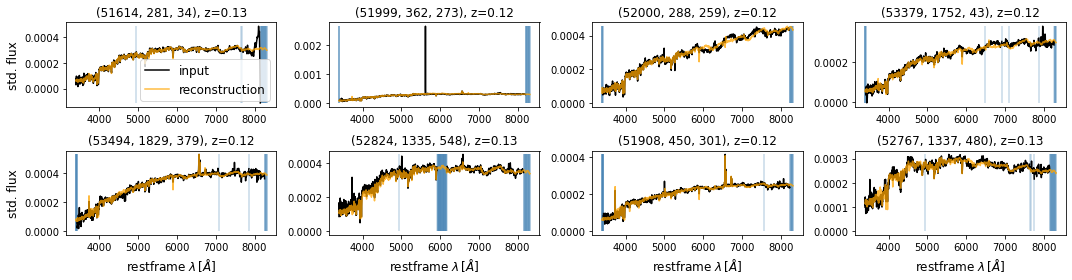

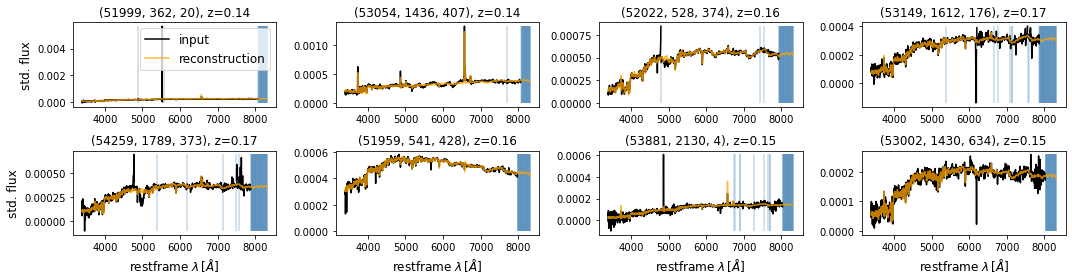

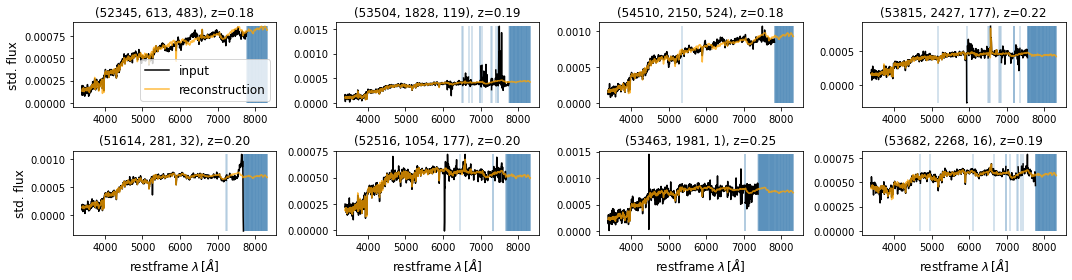

In [46]:
data = test
for mm in np.arange(5):
    ind_ood           = resrAE1[1][mm].index.to_numpy()
    outliers_decoded  = decoded_AE1_test[ind_ood]
    outliers_input    = masked['test'][ind_ood]

    fi, ax = plt.subplots(2,4,figsize=(15,4))
    ax = ax.flatten()
    for ii in range(0,8):
        ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
        ax[ii].plot(new_wl[1:],outliers_input[ii]/new_wl[1:], color='black', label='input', lw=1.5)
        #ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]),min(data['spec'][ind_ood][ii])),ymax=max(max(outliers_decoded[ii]),max(data['spec'][ind_ood][ii])), color='steelblue',alpha=0.3)
        ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]/new_wl[1:]),min(data['spec'][ind_ood][ii][:,0]/new_wl[1:])),ymax=max(max(outliers_decoded[ii]/new_wl[1:]),max(data['spec'][ind_ood][ii][:,0]/new_wl[1:])), color='steelblue',alpha=0.3)

        ax[ii].plot(new_wl[1:],outliers_decoded[ii]/new_wl[1:], label='reconstruction',ls='-', color='orange', lw=1.5, alpha=0.75)
        if ii ==0:
            ax[ii].legend()
        if ii in [4,5,6,7]:
            ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
        if ii%4==0:
            ax[ii].set_ylabel(r'std. flux')        
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.17, hspace=0.4)
    plt.savefig(os.path.join(plotpath,'Figure9_alternative_%d.pdf'%mm), bbox_inches='tight')
    plt.show()
    plt.close()

In [69]:
data = df_test[(df_test['new_label']==0)|(df_test['new_label']==1)]
data_cut1 = data[(np.log(data['recon_error'])<0.4)&(data['logp_marg_corr']<-24)]
data_cut2 = data[(np.log(data['recon_error'])>1)&(data['logp_marg_corr']>1)]
len(data_cut1),len(data_cut2)

(6, 6)

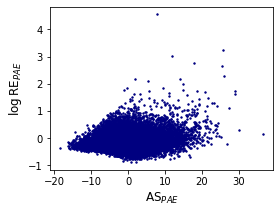

In [75]:

plt.figure(figsize=(4,3))
plt.scatter(-data['logp_marg_corr'],np.log(data['recon_error']),s=2,color='navy')#, label='pearson correlation = %.2f'%scipy.stats.pearsonr(-data['logp_marg_corr'],np.log(data['recon_error']))[0])
#plt.scatter(-data_cut1['logp_marg_corr'],np.log(data_cut1['recon_error']),s=4,color='red')#, label='pearson correlation = %.2f'%scipy.stats.pearsonr(-data['logp_marg_corr'],np.log(data['recon_error']))[0])
#plt.scatter(-data_cut2['logp_marg_corr'],np.log(data_cut2['recon_error']),s=4,color='lightseagreen')#, label='pearson correlation = %.2f'%scipy.stats.pearsonr(-data['logp_marg_corr'],np.log(data['recon_error']))[0])

plt.xlabel('$\mathrm{AS}_{PAE}$')
plt.ylabel('$\log\,\mathrm{RE}_{PAE}$')
plt.savefig(os.path.join(plotpath,'Figure11.pdf'),bbox_inches='tight')
#plt.ylim(-1,4)

In [78]:
scipy.stats.pearsonr(-data['logp_marg_corr'],np.log(data['recon_error'])),scipy.stats.spearmanr(-data['logp_marg_corr'],np.log(data['recon_error']))

((0.20207818694822544, 0.0),
 SpearmanrResult(correlation=0.1194940084029872, pvalue=1.7471127215255878e-228))

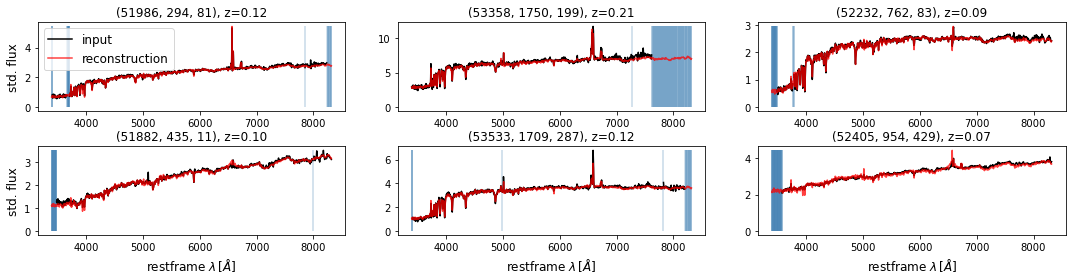

In [37]:
data = test

ind_ood           = data_cut1.index.to_numpy()
outliers_decoded  = decoded['test'][ind_ood]
outliers_input    = masked['test'][ind_ood]

fi, ax = plt.subplots(2,3,figsize=(15,4))
ax = ax.flatten()
for ii in range(0,6):
    ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
    ax[ii].plot(new_wl[1:],outliers_input[ii], color='black', label='input', lw=1.5)
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]),min(data['spec'][ind_ood][ii])),ymax=max(max(outliers_decoded[ii]),max(data['spec'][ind_ood][ii])), color='steelblue',alpha=0.3)
    ax[ii].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='red', lw=1.5, alpha=0.75)
    if ii ==0:
        ax[ii].legend()
    if ii in [3,4,5]:
        ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
    if ii%3==0:
        ax[ii].set_ylabel(r'std. flux')        
plt.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0.4)
plt.savefig(os.path.join(plotpath,'lowlogp_lowrecon.pdf'%mm), bbox_inches='tight')
plt.show()
plt.close()

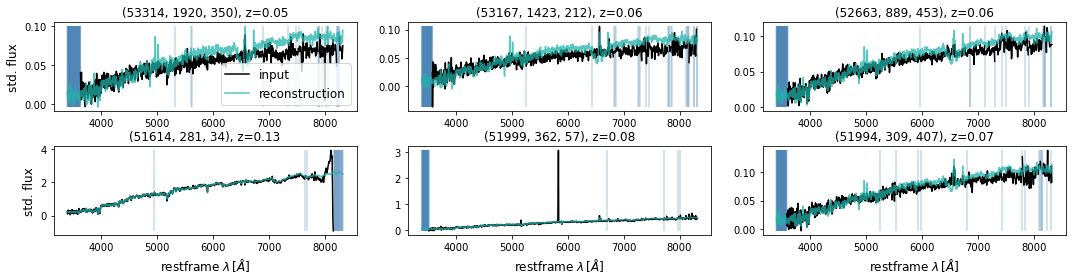

In [38]:
data = test

ind_ood           = data_cut2.index.to_numpy()
outliers_decoded  = decoded['test'][ind_ood]
outliers_input    = masked['test'][ind_ood]

fi, ax = plt.subplots(2,3,figsize=(15,4))
ax = ax.flatten()
for ii in range(0,6):
    ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
    ax[ii].plot(new_wl[1:],outliers_input[ii], color='black', label='input', lw=1.5)
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]),min(data['spec'][ind_ood][ii])),ymax=max(max(outliers_decoded[ii]),max(data['spec'][ind_ood][ii])), color='steelblue',alpha=0.3)
    ax[ii].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='lightseagreen', lw=1.5, alpha=0.75)
    if ii ==0:
        ax[ii].legend()
    if ii in [3,4,5]:
        ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
    if ii%3==0:
        ax[ii].set_ylabel(r'std. flux')        
plt.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0.4)
plt.savefig(os.path.join(plotpath,'highlogp_highrecon.pdf'%mm), bbox_inches='tight')
plt.show()
plt.close()

In [90]:
data = df_overlap_test[(df_overlap_test['new_label']==0)|(df_overlap_test['new_label']==1)]
data_cut1 = data[(data[' weirdness']<0.43)&(data['logp_marg_corr']<-20)]
data_cut2 = data[(data[' weirdness']>0.688)&(data['logp_marg_corr']>-10)]
len(data_cut1),len(data_cut2)

(6, 6)

In [91]:
data.columns

Index(['index', 'plate', ' mjd', ' fiber', ' weirdness', 'level_0',
       'Unnamed: 0', 'new_label', 'RA', 'logp_marg', 'mask_fracs', 'z',
       'recon_error_std', 'recon_error', 'max_recon_error', 'supernova',
       'logp', 'logp_marg_corr', 'DEC'],
      dtype='object')

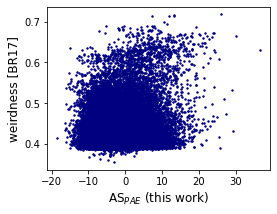

In [95]:
plt.figure(figsize=(4,3))
plt.scatter(-data['logp_marg_corr'],data[' weirdness'],s=2,color='navy')#, label='pearson correlation = %.2f'%scipy.stats.pearsonr(-data['logp_marg_corr'],data[' weirdness'])[0])
#plt.scatter(-data_cut1['logp_marg_corr'],data_cut1[' weirdness'],s=2,color='red')
##plt.scatter(-data_cut2['logp_marg_corr'],data_cut2[' weirdness'],s=2,color='lightseagreen')
#plt.xlabel('PAE anomlay score (this work)')
plt.ylabel('weirdness [BR17]')
plt.xlabel('$\mathrm{AS}_{PAE}$ (this work)')
plt.savefig(os.path.join(plotpath,'Figure12.pdf'),bbox_inches='tight')
#plt.legend()

In [94]:
scipy.stats.pearsonr(-data['logp_marg_corr'],data[' weirdness']),scipy.stats.spearmanr(-data['logp_marg_corr'],data[' weirdness'])

((0.1800934858426107, 0.0),
 SpearmanrResult(correlation=0.0900017332261119, pvalue=4.1998412212793044e-130))

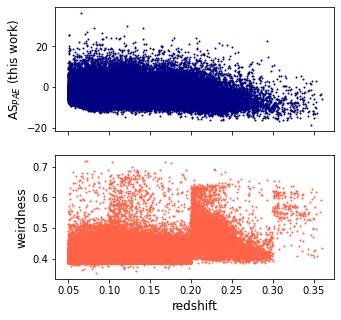

In [96]:
# plt.figure()
# plt.scatter(data['z'],data[' weirdness'],s=2)
# plt.scatter(data['z'],-data['logp_marg_corr'],s=2)
# plt.xlabel('weirdness')
# plt.xlabel('redshift')

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True,figsize=(5,5)) 
  
ax2.set_xlabel('redshift') 
ax1.set_ylabel('$\mathrm{AS}_{PAE}$ (this work)')

ax1.tick_params(axis ='y', labelcolor = 'black') 
ax2.set_ylabel('weirdness') 
plot_1 = ax2.scatter(data['z'],data[' weirdness'],s=1, color='tomato')
plot_2 = ax1.scatter(data['z'],-data['logp_marg_corr'],s=1, color='navy')

ax2.tick_params(axis ='y') 

plt.savefig(os.path.join(plotpath,'Figure13.pdf'),bbox_inches='tight')

plt.show()

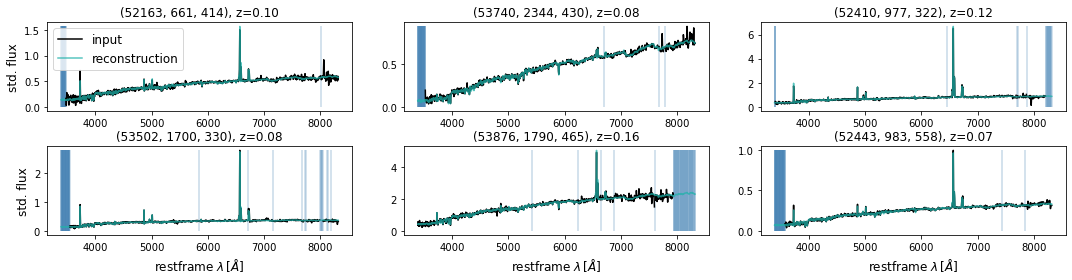

In [42]:
data = test

ind_ood           = data_cut2.index.to_numpy()
outliers_decoded  = decoded['test'][ind_ood]
outliers_input    = masked['test'][ind_ood]

fi, ax = plt.subplots(2,3,figsize=(15,4))
ax = ax.flatten()
for ii in range(0,6):
    ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
    ax[ii].plot(new_wl[1:],outliers_input[ii], color='black', label='input', lw=1.5)
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]),min(data['spec'][ind_ood][ii])),ymax=max(max(outliers_decoded[ii]),max(data['spec'][ind_ood][ii])), color='steelblue',alpha=0.3)
    ax[ii].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='lightseagreen', lw=1.5, alpha=0.75)
    if ii ==0:
        ax[ii].legend()
    if ii in [3,4,5]:
        ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
    if ii%3==0:
        ax[ii].set_ylabel(r'std. flux')        
plt.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0.4)
plt.savefig(os.path.join(plotpath,'highlogp_highw.pdf'%mm), bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
data = test

ind_ood           = data_cut1.index.to_numpy()
outliers_decoded  = decoded['test'][ind_ood]
outliers_input    = masked['test'][ind_ood]

fi, ax = plt.subplots(2,3,figsize=(15,4))
ax = ax.flatten()
for ii in range(0,6):
    ax[ii].set_title('(%d, %d, %d), z=%.2f'%(data['MJD'][ind_ood][ii],data['plate'][ind_ood][ii],data['fiber'][ind_ood][ii],data['z'][ind_ood][ii]))
    ax[ii].plot(new_wl[1:],outliers_input[ii], color='black', label='input', lw=1.5)
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind_ood][ii].astype(bool))], ymin=min(min(outliers_decoded[ii]),min(data['spec'][ind_ood][ii])),ymax=max(max(outliers_decoded[ii]),max(data['spec'][ind_ood][ii])), color='steelblue',alpha=0.3)
    ax[ii].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='red', lw=1.5, alpha=0.75)
    if ii ==0:
        ax[ii].legend()
    if ii in [3,4,5]:
        ax[ii].set_xlabel(r'restframe $\lambda \, [\AA]$')
    if ii%3==0:
        ax[ii].set_ylabel(r'std. flux')        
plt.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0.4)
plt.savefig(os.path.join(plotpath,'lowlogp_loww.pdf'%mm), bbox_inches='tight')
plt.show()
plt.close()